# Example: Image Reconstruction
We know turn our attention to a complicated, "large scale" demonstration of the techniques which we have just reviewed in the previous notebooks. Here, we will look at a compressed sensing *image reconstruction* problem.

We will assume that we have some manner by which we can acquire random samples of a square image which is of size ($512\times 512$), which comes out to $N = 262144$, a problem size which far surpasses our ability to use random, dense sampling matrices.

We need to devise both a sampling method and a reconstruction approach which are well suited for problems of this size.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pywt as pw
import scipy.fftpack as fp
import scipy.linalg as la       
import scipy.signal as sig
from scipy import misc

In [2]:
def MSE(x,y):
    mseval = np.mean(np.power(x-y,2))    
    return mseval

def normalize(x):
    y = (x - min(x))/(max(x)-min(x))
    return y

class SRM:
    def __init__(self,m,n,blksize):
        self.n = n
        self.m = m
        self.blksize = blksize
        self.random_perm = np.random.permutation(n)
        self.select_vect = np.random.permutation(n)[:m]
        self.D = fp.dct(np.eye(blksize),norm='ortho',type=3)
        self.blkshape = (blksize,n/blksize)
        
    def forward(self,x):
        y = np.asarray(x)
        y = y[self.random_perm]
        y = np.reshape(y,self.blkshape)
        y = np.dot(self.D,y)
        y = np.reshape(y,(self.n,1))
        y = y[self.select_vect]
        return y
    
    def transpose(self,y):
        x = np.zeros((self.n,1))
        x[self.select_vect] = y
        x = np.reshape(x,self.blkshape)
        x = np.dot(self.D.T,x);
        x = np.reshape(x,(self.n,1))
        x = x[np.argsort(self.random_perm)]
        
        return x

    
def DoubleExpand(x):
    r,c = np.shape(x)
    X = np.zeros((2*r,2*c))
    X[0::2,0::2] = x
    X[1::2,0::2] = x
    X[0::2,1::2] = x
    X[1::2,1::2] = x
    
    return X
    
    
def bishrink(w,wParent,beta):
    s = np.power(np.abs(w),2)
    sParent = np.power(np.abs(wParent),2)
    R = np.sqrt(s + sParent)
    R[R<beta] = 0.0
    R = np.divide(R,R+beta)
    wFinal = np.multiply(w,R)
    
    return wFinal
    
def BivariateShrinkage(W,end_level,lam):
    windowsize = 3
    eps = 1e-6
    windowfilt = np.ones((windowsize,windowsize))/(windowsize*windowsize)
    L = np.shape(W)[0]
    # Check noise sig on the highest detail diagonal
    NoiseSig = np.median(abs(W[L-1][2]))/0.6745
    NoiseVar = NoiseSig*NoiseSig
    
    for scale in (range(0,L)[:end_level:-1]):
        for dir in [0,1,2]:
            w = W[scale][dir]
            wParent = DoubleExpand(W[scale-1][dir])
            
            Wsig = sig.convolve2d(np.power(w,2),windowfilt,mode='same',boundary='symm')
            Ssig = np.sqrt(np.max(Wsig - NoiseVar,eps))
            
            T = np.sqrt(3)*NoiseVar/Ssig
            
            W[scale][dir] = bishrink(w,wParent,T*lam)
    
    return W
    
def ISTImageRecovery(F,y,imshape,lam,iters,xtrue):
    wfilter = 'db1'
    vecshape = (F.n,1)
    L = 5
    x = np.zeros((F.n,1))
    xlast = np.zeros((F.n,1))
    for i in range(1,iters):
        r = y - F.forward(x)
        z = x + F.transpose(r)
        # Transform into wavelet coefficients
        zim = np.reshape(z,imshape)
        wim = pw.wavedec2(zim,wfilter,mode='sym',level=L)
        # From Tuple->List
        wim = list(wim)
        for l in range(0,L+1):
            wim[l] = list(wim[l])
        # Apply Shrinkage
        wim = BivariateShrinkage(wim,1,lam)
        # Back to image space  
        xim = pw.waverec2(wim,wfilter,mode='sym')
        xlast = x
        x = np.reshape(xim,vecshape)
        
        conv = MSE(x,xlast)
        mseval = MSE(x,xtrue)
        
        if conv < 1e-7:
            break
        
        print "[%d] Conv : %.3e | MSE : %.3e" % (i,conv,mseval)
        
    x = np.reshape(x,imshape)
    return x

In [5]:
im = misc.lena().astype(np.float32)

N = np.size(im)
M = int(round(0.25*N))
imshape = np.shape(im)

F = SRM(M,N,32)
x = np.reshape(im,(N,1))
x = normalize(x)
y = F.forward(x)

xt = ISTImageRecovery(F,y,imshape,20,100,x)

[1] Conv : 1.627e-02 | MSE : 1.422e-01
[2] Conv : 8.818e-03 | MSE : 8.328e-02
[3] Conv : 4.848e-03 | MSE : 5.037e-02
[4] Conv : 2.700e-03 | MSE : 3.172e-02
[5] Conv : 1.537e-03 | MSE : 2.085e-02
[6] Conv : 8.910e-04 | MSE : 1.436e-02
[7] Conv : 5.343e-04 | MSE : 1.032e-02
[8] Conv : 3.274e-04 | MSE : 7.745e-03
[9] Conv : 2.076e-04 | MSE : 6.035e-03
[10] Conv : 1.366e-04 | MSE : 4.852e-03
[11] Conv : 9.201e-05 | MSE : 4.014e-03
[12] Conv : 6.430e-05 | MSE : 3.397e-03
[13] Conv : 4.604e-05 | MSE : 2.933e-03
[14] Conv : 3.289e-05 | MSE : 2.582e-03
[15] Conv : 2.446e-05 | MSE : 2.308e-03
[16] Conv : 1.829e-05 | MSE : 2.094e-03
[17] Conv : 1.437e-05 | MSE : 1.921e-03
[18] Conv : 1.108e-05 | MSE : 1.782e-03
[19] Conv : 9.031e-06 | MSE : 1.666e-03
[20] Conv : 7.306e-06 | MSE : 1.571e-03
[21] Conv : 6.019e-06 | MSE : 1.491e-03
[22] Conv : 5.047e-06 | MSE : 1.424e-03
[23] Conv : 4.314e-06 | MSE : 1.368e-03
[24] Conv : 3.618e-06 | MSE : 1.321e-03
[25] Conv : 3.083e-06 | MSE : 1.281e-03
[26] Conv

/Users/eric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in sqrt
/Users/eric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in less
/Users/eric/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)



[39] Conv : nan | MSE : nan
[40] Conv : nan | MSE : nan
[41] Conv : nan | MSE : nan
[42] Conv : nan | MSE : nan
[43] Conv : nan | MSE : nan
[44] Conv : nan | MSE : nan
[45] Conv : nan | MSE : nan
[46] Conv : nan | MSE : nan
[47] Conv : nan | MSE : nan
[48] Conv : nan | MSE : nan
[49] Conv : nan | MSE : nan
[50] Conv : nan | MSE : nan
[51] Conv : nan | MSE : nan
[52] Conv : nan | MSE : nan
[53] Conv : nan | MSE : nan
[54] Conv : nan | MSE : nan
[55] Conv : nan | MSE : nan
[56] Conv : nan | MSE : nan
[57] Conv : nan | MSE : nan
[58] Conv : nan | MSE : nan
[59] Conv : nan | MSE : nan
[60] Conv : nan | MSE : nan
[61] Conv : nan | MSE : nan
[62] Conv : nan | MSE : nan
[63] Conv : nan | MSE : nan
[64] Conv : nan | MSE : nan
[65] Conv : nan | MSE : nan
[66] Conv : nan | MSE : nan
[67] Conv : nan | MSE : nan
[68] Conv : nan | MSE : nan
[69] Conv : nan | MSE : nan
[70] Conv : nan | MSE : nan
[71] Conv : nan | MSE : nan
[72] Conv : nan | MSE : nan
[73] Conv : nan | MSE : nan
[74] Conv : nan | M

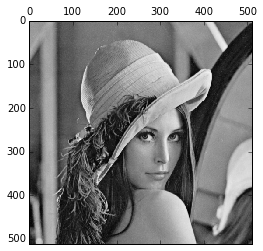

/Users/eric/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


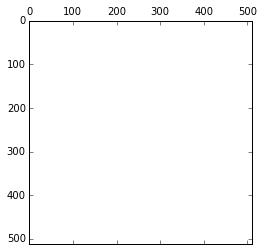

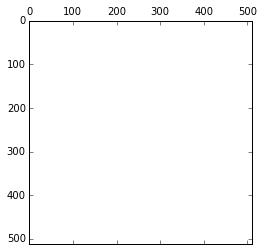

In [6]:
xim = np.reshape(x,imshape)
plt.matshow(np.reshape(x,imshape));
plt.gray()

plt.matshow(xt);
plt.gray()

plt.matshow(abs(xim-xt));
plt.jet()

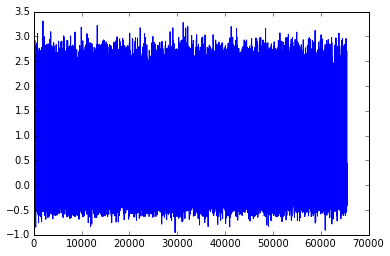

In [4]:
plt.plot(y)